In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import sin, asin, floor, sqrt, pi
import numpy as np
from scipy.linalg import sqrtm, fractional_matrix_power
from qiskit.circuit.library import RXGate
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from scipy.linalg import fractional_matrix_power

def P(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="P")
    for k in reversed(range(2, n + 1)):
        crx = RXGate(pi / (2**(n - k + 1)), label=f"Rx(pi/{2**(n - k + 1)})").control(1)
        qc.append(crx, [k - 1, n])

    return qc

def Q(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="Q")
    for k in reversed(range(1, n)):
        qc.append(multi_controlled_RX(k), range(k + 1))
    
    return qc

def multi_controlled_RX(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="LDD mcRX")
    qc.append(P(n), range(n + 1))
    CRXGate = RXGate(pi / (2**(n - 1)), label=f"Rx(pi/{2**(n - 1)})").control(1)
    qc.append(CRXGate, [0, n])
    qc.append(Q(n), range(n + 1))
    qc.append(P(n).inverse(), range(n + 1))
    qc.append(Q(n).inverse(), range(n + 1))

    return qc

def P_U(n: int, U) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="P_U")
    for k in reversed(range(2, n + 1)):
        U = sqrtm(U)
        cu_gate = UnitaryGate(U, label=f"U^(2^-{n - k + 1})").control(1)
        qc.append(cu_gate, [k - 1, n])

    return qc

def multi_controlled_U(n: int, U) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, name="LDD mcu")
    qc.append(P_U(n, U), range(n + 1))
    root_U = fractional_matrix_power(U, 2**(-n + 1))
    cu_gate = UnitaryGate(root_U, label=f"U^(2^-{n - 1})").control(1)
    qc.append(cu_gate, [0, n])
    qc.append(Q(n), range(n + 1))
    qc.append(P_U(n, U).inverse(), range(n + 1))
    qc.append(Q(n).inverse(), range(n + 1))

    return qc

def test_x(mcu: QuantumCircuit):
    n = mcu.num_qubits - 1
    qc = QuantumCircuit(n + 1)
    qc.x(range(n + 1))
    qc.append(mcu, range(n + 1))
    print(qc.draw(output="text"))
    qc.measure_all()

    backend = Aer.get_backend('aer_simulator')
    compiled = transpile(qc, backend)
    result = backend.run(compiled, shots=rounds).result()
    counts = result.get_counts(compiled)

    if counts.get("0" + "1" * n) == rounds:
        print("Passed: applied all-1 test")
    else:
        print("Failed: did not apply all-1 test")

    qc = QuantumCircuit(n + 1)
    qc.x(range(1, n + 1))
    qc.append(mcu, range(n + 1))
    print(qc.draw(output="text"))
    qc.measure_all()

    backend = Aer.get_backend('aer_simulator')
    compiled = transpile(qc, backend)
    result = backend.run(compiled, shots=rounds).result()
    counts = result.get_counts(compiled)

    if counts.get("0" + "1" * n) != rounds:
        print("Passed: did not apply when first control is 0")
    else:
        print("Failed: still applied when first control is 0")

def test_z(mcu: QuantumCircuit):
    n = mcu.num_qubits - 1
    qc = QuantumCircuit(n + 1)
    qc.x(range(n + 1))
    qc.h(n)
    qc.append(mcu, range(n + 1))
    qc.h(n)
    print(qc.draw(output="text"))
    qc.measure_all()

    backend = Aer.get_backend('aer_simulator')
    compiled = transpile(qc, backend)
    result = backend.run(compiled, shots=rounds).result()
    counts = result.get_counts(compiled)

    if counts.get("0" + "1" * n) == rounds:
        print("Passed: applied all-1 test")
    else:
        print("Failed: did not apply all-1 test")

    qc = QuantumCircuit(n + 1)
    qc.x(range(1, n + 1))
    qc.h(n)
    qc.append(mcu, range(n + 1))
    qc.h(n)
    print(qc.draw(output="text"))
    qc.measure_all()

    backend = Aer.get_backend('aer_simulator')
    compiled = transpile(qc, backend)
    result = backend.run(compiled, shots=rounds).result()
    counts = result.get_counts(compiled)

    if counts.get("0" + "1" * n) != rounds:
        print("Passed: did not apply when first control is 0")
    else:
        print("Failed: still applied when first control is 0")

n = 5
rounds = 100

U = np.array([
    [0, 1],
    [1, 0]
])

mcu_gate = UnitaryGate(U).control(n)
qc = QuantumCircuit(n + 1, name="Qiskit mcu")
qc.append(mcu_gate, range(n + 1))

print("Testing LLD multi-controlled-U = X:")
test_x(multi_controlled_U(5, U))
print("\nTesting Qiskit multi-controlled-U = X:")
test_x(qc)

U = np.array([
    [1, 0],
    [0, -1]
])
mcu_gate = UnitaryGate(U).control(n)
qc = QuantumCircuit(n + 1, name="Qiskit mcu")
qc.append(mcu_gate, range(n + 1))

print("\nTesting LLD multi-controlled-U = Z:")
test_z(multi_controlled_U(5, U))
print("\nTesting Qiskit multi-controlled-U = Z:")
test_z(qc)

Testing LLD multi-controlled-U = X:
     ┌───┐┌──────────┐
q_0: ┤ X ├┤0         ├
     ├───┤│          │
q_1: ┤ X ├┤1         ├
     ├───┤│          │
q_2: ┤ X ├┤2         ├
     ├───┤│  LDD mcu │
q_3: ┤ X ├┤3         ├
     ├───┤│          │
q_4: ┤ X ├┤4         ├
     ├───┤│          │
q_5: ┤ X ├┤5         ├
     └───┘└──────────┘
Passed: applied all-1 test
          ┌──────────┐
q_0: ─────┤0         ├
     ┌───┐│          │
q_1: ┤ X ├┤1         ├
     ├───┤│          │
q_2: ┤ X ├┤2         ├
     ├───┤│  LDD mcu │
q_3: ┤ X ├┤3         ├
     ├───┤│          │
q_4: ┤ X ├┤4         ├
     ├───┤│          │
q_5: ┤ X ├┤5         ├
     └───┘└──────────┘
Passed: did not apply when first control is 0

Testing Qiskit multi-controlled-U = X:
     ┌───┐┌─────────────┐
q_0: ┤ X ├┤0            ├
     ├───┤│             │
q_1: ┤ X ├┤1            ├
     ├───┤│             │
q_2: ┤ X ├┤2            ├
     ├───┤│  Qiskit mcu │
q_3: ┤ X ├┤3            ├
     ├───┤│             │
q_4: ┤ X ├┤4       

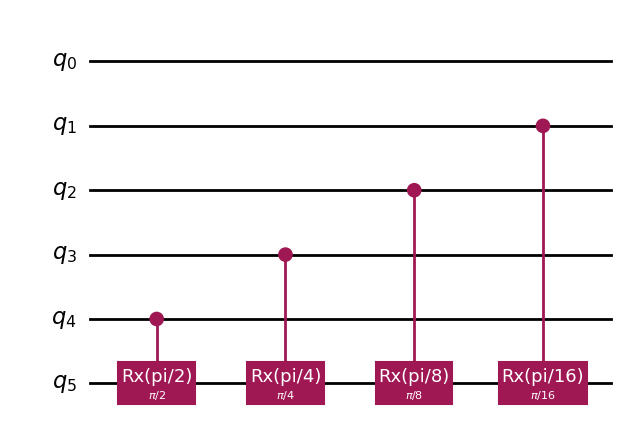

In [9]:
P(n).draw(output="mpl")

Q


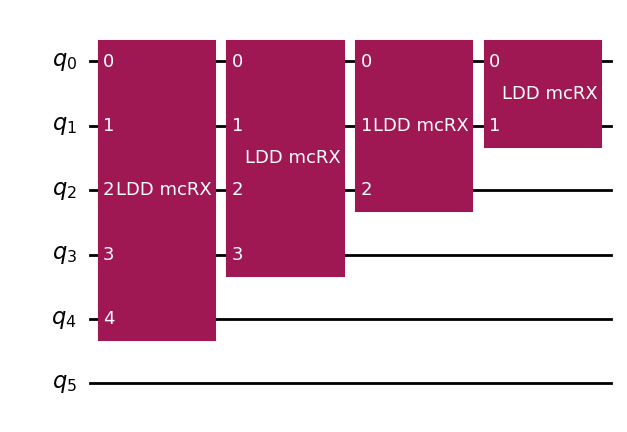

In [ ]:
print("QWE")
Q(n).draw(output="mpl")


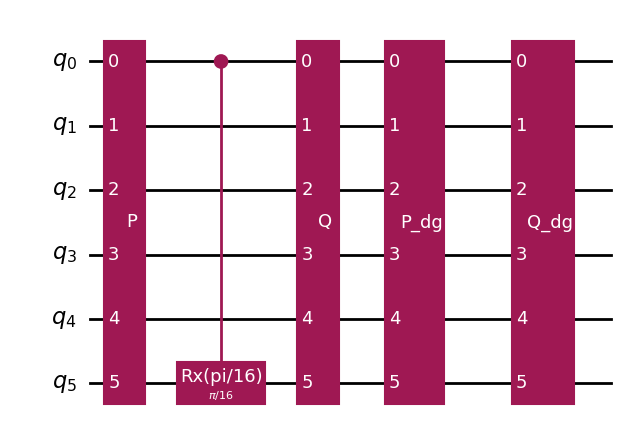

In [11]:
multi_controlled_RX(n).draw(output="mpl")

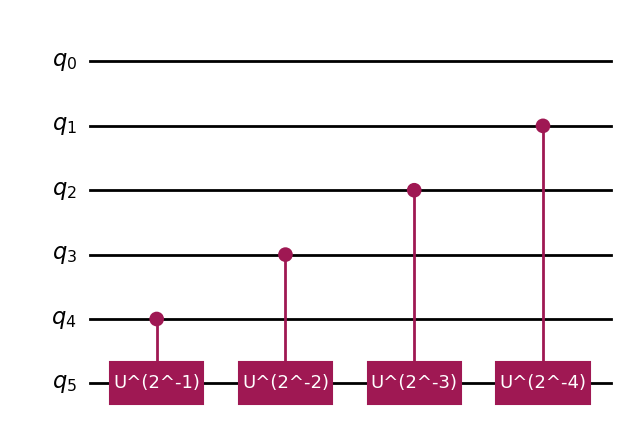

In [12]:
U = np.array([
    [1, 0],
    [0, -1]
])

P_U(n, U).draw(output="mpl")

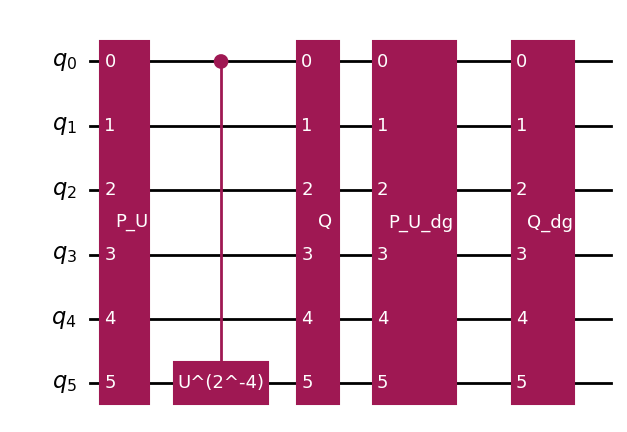

In [13]:
multi_controlled_U(n, U).draw(output="mpl")